In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel("./process_data/dining area.xlsx")
df = df.drop(columns = ["Unnamed: 0"])
df.head()

,start_time,end_time,temperature,luminosity,humidity,motion
0,2022-05-01 00:00:00,2022-05-01 01:30:00,22.031250,0.0,46.61,0
1,2022-05-01 01:30:00,2022-05-01 03:00:00,21.865000,0.0,48.00,1
2,2022-05-01 03:00:00,2022-05-01 04:30:00,21.443333,3.0,48.50,1
3,2022-05-01 04:30:00,2022-05-01 06:00:00,21.360000,69.0,49.00,0
4,2022-05-01 06:00:00,2022-05-01 07:30:00,20.992500,94.0,48.00,0


In [3]:
df["temperature"].describe()

count    7010.000000
mean       23.561677
std         3.609479
min         4.825109
25%        20.421250
50%        23.367222
75%        26.501500
max        35.401667
Name: temperature, dtype: float64

In [4]:
df["humidity"].describe()

count    7010.000000
mean       52.576881
std        11.712454
min         6.936949
25%        44.000000
50%        51.000000
75%        61.000000
max        81.500000
Name: humidity, dtype: float64

In [5]:
df.isna().sum()

start_time     0
end_time       0
temperature    0
luminosity     0
humidity       0
motion         0
dtype: int64

# 1. Data preprocessing

- Chia dữ liệu intervals thành dữ liệu time-series. Có 2 khoảng thời gian chính bao gồm:
    - `4:30`: `12:00`
    - `12:30`: `22:30`

- Normalization

## 1.1. Normalization

In [6]:
datatypes = [col for col in df.columns if col not in {"start_time", "end_time"}]

normalized_df = df.copy()
for datatype in datatypes:
    scaler = MinMaxScaler()
    data = torch.Tensor(normalized_df[datatype].tolist()).reshape(-1, 1)
    scaler.fit(data)

    normalized_df[datatype] = scaler.transform(data)

In [7]:
print(df.head(2))
print("---------------------------------------------")
print(normalized_df.head(2))

           start_time            end_time  temperature  luminosity  humidity  \
0 2022-05-01 00:00:00 2022-05-01 01:30:00     22.03125         0.0     46.61   
1 2022-05-01 01:30:00 2022-05-01 03:00:00     21.86500         0.0     48.00   

   motion  
0       0  
1       1  
---------------------------------------------
           start_time            end_time  temperature  luminosity  humidity  \
0 2022-05-01 00:00:00 2022-05-01 01:30:00     0.562723         0.0  0.532074   
1 2022-05-01 01:30:00 2022-05-01 03:00:00     0.557286         0.0  0.550716   

     motion  
0  0.000000  
1  0.002445  


## 1.1. Data segmentation

Chia dữ liệu thành:
- `4:30` -> `12:00`
- `12:30` -> `22:30`

### 1.1.1. Time-series & one dimesion

In [8]:
morning_start = pd.to_datetime("04:30:00").time()
morning_end = pd.to_datetime("12:00:00").time()

afternoon_start = pd.to_datetime("12:00:00").time()
afternoon_end = pd.to_datetime("20:30:00").time()

In [9]:
dates = normalized_df["start_time"].dt.date.unique()

df_data = {
    "date": [],
    "time": [],
    "temperature": [],
    "luminosity": [],
    "humidity": [],
    "motion": []
}

In [10]:
for date in dates:
    rows = normalized_df[
        normalized_df["start_time"].dt.date == date
    ]

    """---------------MORNING TIME---------------"""
    morning_df = rows[
        (rows["start_time"].dt.time >= morning_start) &
        (rows["start_time"].dt.time <= morning_end) &
        (rows["end_time"].dt.time <= morning_end)
    ].sort_values("start_time")

    for datatype in datatypes:
        df_data[datatype].append(
            np.array(
                morning_df[datatype].tolist()
            )
        )

    df_data["date"].append(date)
    df_data["time"].append(f"{morning_start} - {morning_end}")

    """---------------AFTERNOON TIME--------------"""
    afternoon_df = rows[
        (rows["start_time"].dt.time >= afternoon_start) &
        (rows["start_time"].dt.time <= afternoon_end) &
        (rows["end_time"].dt.time <= afternoon_end)
    ]

    for datatype in datatypes:
        df_data[datatype].append(
            np.array(
                afternoon_df[datatype].tolist()
            )
        )

    df_data["date"].append(date)
    df_data["time"].append(f"{afternoon_start} - {afternoon_end}")

In [11]:
time_df = pd.DataFrame(df_data)
time_df.head(10)

,date,time,temperature,luminosity,humidity,motion
0,2022-05-01,04:30:00 - 12:00:00,"[0.5407701727467595, 0.5287511517583859, 0.523...","[0.04202192448233861, 0.05724725943970767, 0.0...","[0.5641272793079329, 0.5507158109789462, 0.537...","[0.0, 0.0, 0.004889975550122249, 0.00977995110..."
1,2022-05-01,12:00:00 - 20:30:00,"[0.6737696263652443, 0.6129114961128564, 0.616...","[0.08404384896467722, 0.06394640682095006, 0.0...","[0.3763667227021194, 0.36295525437313275, 0.36...","[0.007334963325183374, 0.007334963325183374, 0..."
2,2022-05-02,04:30:00 - 12:00:00,"[0.5307988192570072, 0.5329482276223272, 0.532...","[0.029232643118148598, 0.06151035322777101, 0....","[0.5373043426499595, 0.5976559501303996, 0.530...","[0.0024449877750611247, 0.009779951100244499, ..."
3,2022-05-02,12:00:00 - 20:30:00,"[0.6526205633948837, 0.6408468183647317, 0.624...","[0.6741778319123021, 0.07338611449451887, 0.03...","[0.3763667227021194, 0.36295525437313275, 0.36...","[0.0, 0.0, 0.012224938875305624, 0.01466992665..."
4,2022-05-03,04:30:00 - 12:00:00,"[0.5451853271330666, 0.5458393755618438, 0.545...","[0.049939098660170524, 0.055420219244823384, 0...","[0.6043616842948929, 0.5775387476369196, 0.564...","[0.012224938875305624, 0.0024449877750611247, ..."
5,2022-05-03,12:00:00 - 20:30:00,"[0.6270744984552667, 0.6323435649962263, 0.619...","[0.3861144945188794, 0.08952496954933008, 0.02...","[0.4300125960180662, 0.4300125960180662, 0.456...","[0.0, 0.0, 0.007334963325183374, 0.00244498777..."
6,2022-05-04,04:30:00 - 12:00:00,"[0.5307134218035979, 0.5329210301864715, 0.534...","[0.008526187576126675, 0.07277710109622411, 0....","[0.644596089281853, 0.6311846209528663, 0.6445...","[0.004889975550122249, 0.009779951100244499, 0..."
7,2022-05-04,12:00:00 - 20:30:00,"[0.6365134434243119, 0.6224776327601349, 0.612...","[0.40255785627283797, 0.11297198538367843, 0.0...","[0.4233068618535728, 0.4233068618535728, 0.443...","[0.0024449877750611247, 0.007334963325183374, ..."
8,2022-05-05,04:30:00 - 12:00:00,"[0.5335750786152488, 0.5348833002316835, 0.536...","[0.005176613885505481, 0.021315468940316686, 0...","[0.644596089281853, 0.725064899255773, 0.69824...","[0.009779951100244499, 0.009779951100244499, 0..."
9,2022-05-05,12:00:00 - 20:30:00,"[0.5420783319837541, 0.5407701727467595, 0.531...","[0.06760048721071864, 0.06151035322777101, 0.0...","[0.6580075576108396, 0.6580075576108396, 0.651...","[0.0, 0.004889975550122249, 0.0073349633251833..."


### 1.1.2. Time-series & multi-dimension

In [12]:
preprocessed_df = {
    "date": [],
    "time": [],
    "data": []
}

In [13]:
for index, row in time_df.iterrows():
    data = row[datatypes[0]]
    
    for i in range(1, len(datatypes)):
        datatype = datatypes[i]

        data = np.vstack((data, row[datatype]))
        data = torch.from_numpy(data)
        data = torch.squeeze(data)

    preprocessed_df["date"].append(row["date"])
    preprocessed_df["time"].append(row["time"])
    preprocessed_df["data"].append(data)

In [14]:
preprocessed_df = pd.DataFrame(preprocessed_df)
preprocessed_df.head(5)

,date,time,data
0,2022-05-01,04:30:00 - 12:00:00,"[[tensor(0.5408, dtype=torch.float64), tensor(..."
1,2022-05-01,12:00:00 - 20:30:00,"[[tensor(0.6738, dtype=torch.float64), tensor(..."
2,2022-05-02,04:30:00 - 12:00:00,"[[tensor(0.5308, dtype=torch.float64), tensor(..."
3,2022-05-02,12:00:00 - 20:30:00,"[[tensor(0.6526, dtype=torch.float64), tensor(..."
4,2022-05-03,04:30:00 - 12:00:00,"[[tensor(0.5452, dtype=torch.float64), tensor(..."


In [15]:
preprocessed_df.loc[0]["data"]

tensor([[0.5408, 0.5288, 0.5232, 0.5509, 0.6220],
        [0.0420, 0.0572, 0.0859, 0.2476, 0.2034],
        [0.5641, 0.5507, 0.5373, 0.5105, 0.4770],
        [0.0000, 0.0000, 0.0049, 0.0098, 0.0171]], dtype=torch.float64)

In [16]:
preprocessed_df.loc[0]["data"].shape

torch.Size([4, 5])

In [17]:
preprocessed_df = preprocessed_df.drop(
    index=preprocessed_df[
        preprocessed_df["data"].apply(lambda x: x.shape != torch.Size([4, 5]))
    ].index
).reset_index(drop=True)

preprocessed_df.head(10)

,date,time,data
0,2022-05-01,04:30:00 - 12:00:00,"[[tensor(0.5408, dtype=torch.float64), tensor(..."
1,2022-05-01,12:00:00 - 20:30:00,"[[tensor(0.6738, dtype=torch.float64), tensor(..."
2,2022-05-02,04:30:00 - 12:00:00,"[[tensor(0.5308, dtype=torch.float64), tensor(..."
3,2022-05-02,12:00:00 - 20:30:00,"[[tensor(0.6526, dtype=torch.float64), tensor(..."
4,2022-05-03,04:30:00 - 12:00:00,"[[tensor(0.5452, dtype=torch.float64), tensor(..."
5,2022-05-03,12:00:00 - 20:30:00,"[[tensor(0.6271, dtype=torch.float64), tensor(..."
6,2022-05-04,04:30:00 - 12:00:00,"[[tensor(0.5307, dtype=torch.float64), tensor(..."
7,2022-05-04,12:00:00 - 20:30:00,"[[tensor(0.6365, dtype=torch.float64), tensor(..."
8,2022-05-05,04:30:00 - 12:00:00,"[[tensor(0.5336, dtype=torch.float64), tensor(..."
9,2022-05-05,12:00:00 - 20:30:00,"[[tensor(0.5421, dtype=torch.float64), tensor(..."


In [18]:
data = torch.stack(
    tuple(preprocessed_df["data"])
)

In [19]:
data.shape

torch.Size([876, 4, 5])

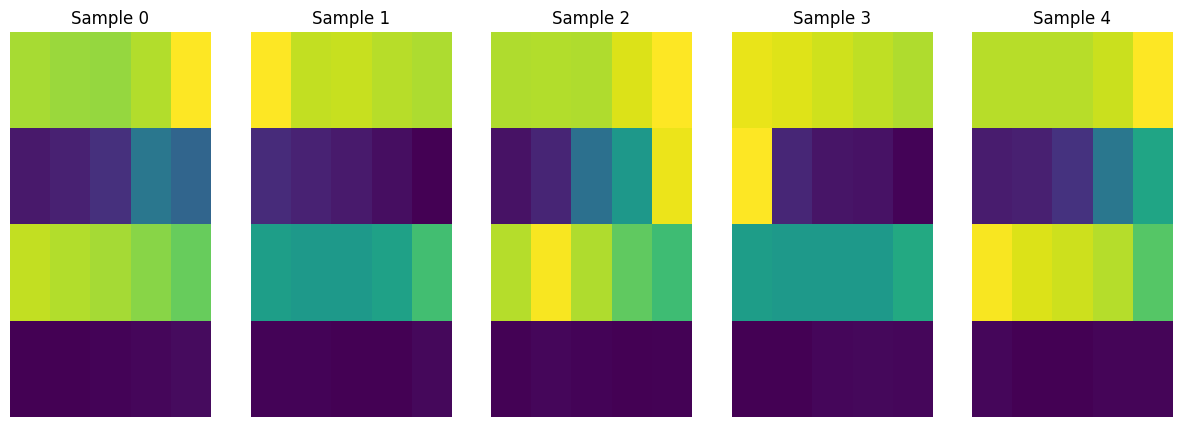

In [20]:
num_samples = 5  # Số lượng ma trận muốn hiển thị
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(data[i], cmap='viridis', aspect='auto')
    ax.set_title(f"Sample {i}")
    ax.axis("off")

plt.show()

In [24]:
import plotly.graph_objects as go
import numpy as np

# Chuyển tensor sang numpy và lấy một số lượng nhỏ để trực quan hóa
num_layers = 20  # Số lớp cần hiển thị (tăng lên nếu muốn hình hộp lớn hơn)
data_np = data[:num_layers].numpy()

# Tạo hình hộp bằng cách xếp từng heatmap lên trục Z
fig = go.Figure()

for i in range(num_layers):
    fig.add_trace(
        go.Surface(
            z=np.full((4, 5), i),  # Đặt layer ở vị trí z = i
            x=np.arange(5),  # Trục X (5 cột)
            y=np.arange(4),  # Trục Y (4 hàng)
            surfacecolor=data_np[i],  # Giá trị màu từ ma trận 4x5
            colorscale="viridis",  # Bảng màu
            showscale=True  # Hiển thị thang đo
        )
    )

# Cấu hình layout để dễ quan sát hơn
fig.update_layout(
    title="Stacked Heatmaps forming a 3D Cube",
    scene=dict(
        xaxis_title="Columns (5)",
        yaxis_title="Rows (4)",
        zaxis_title="Time steps",
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)  # Mở rộng góc nhìn
        ),
    ),
    width=1000,  # Mở rộng plot
    height=800
)

fig.show()